# Segmenting and Clustering Neighborhoods in Toronto

## -->Description 

For this assignment, we are required to explore, segment, and cluster the neighborhoods in the city of Toronto. 

However, unlike New York's practice, the neighborhood data is not readily available on the internet. Something interesting about the field of data science is that each project can be challenging in its unique way, so we need to learn to be agile and refine the skill to learn new libraries and tools quickly depending on the project.

For the Toronto neighborhood data, a Wikipedia page exists that has all the information we need to explore and cluster the neighborhoods in Toronto. We are required to scrape the Wikipedia page and wrangle the data, clean it, and then read it into a pandas dataframe so that it is in a structured format like the New York dataset.

Once the data is in a structured format, we can replicate the analysis that we did to the New York City dataset to explore and cluster the neighborhoods in the city of Toronto.

We start by creating a new Notebook for this assignment. Hence, we are using such Notebook to build the code to scrape the following Wikipedia page: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M, in order to obtain the data that is in the table of postal codes and to transform the data into a pandas dataframe similar to the one presented here:



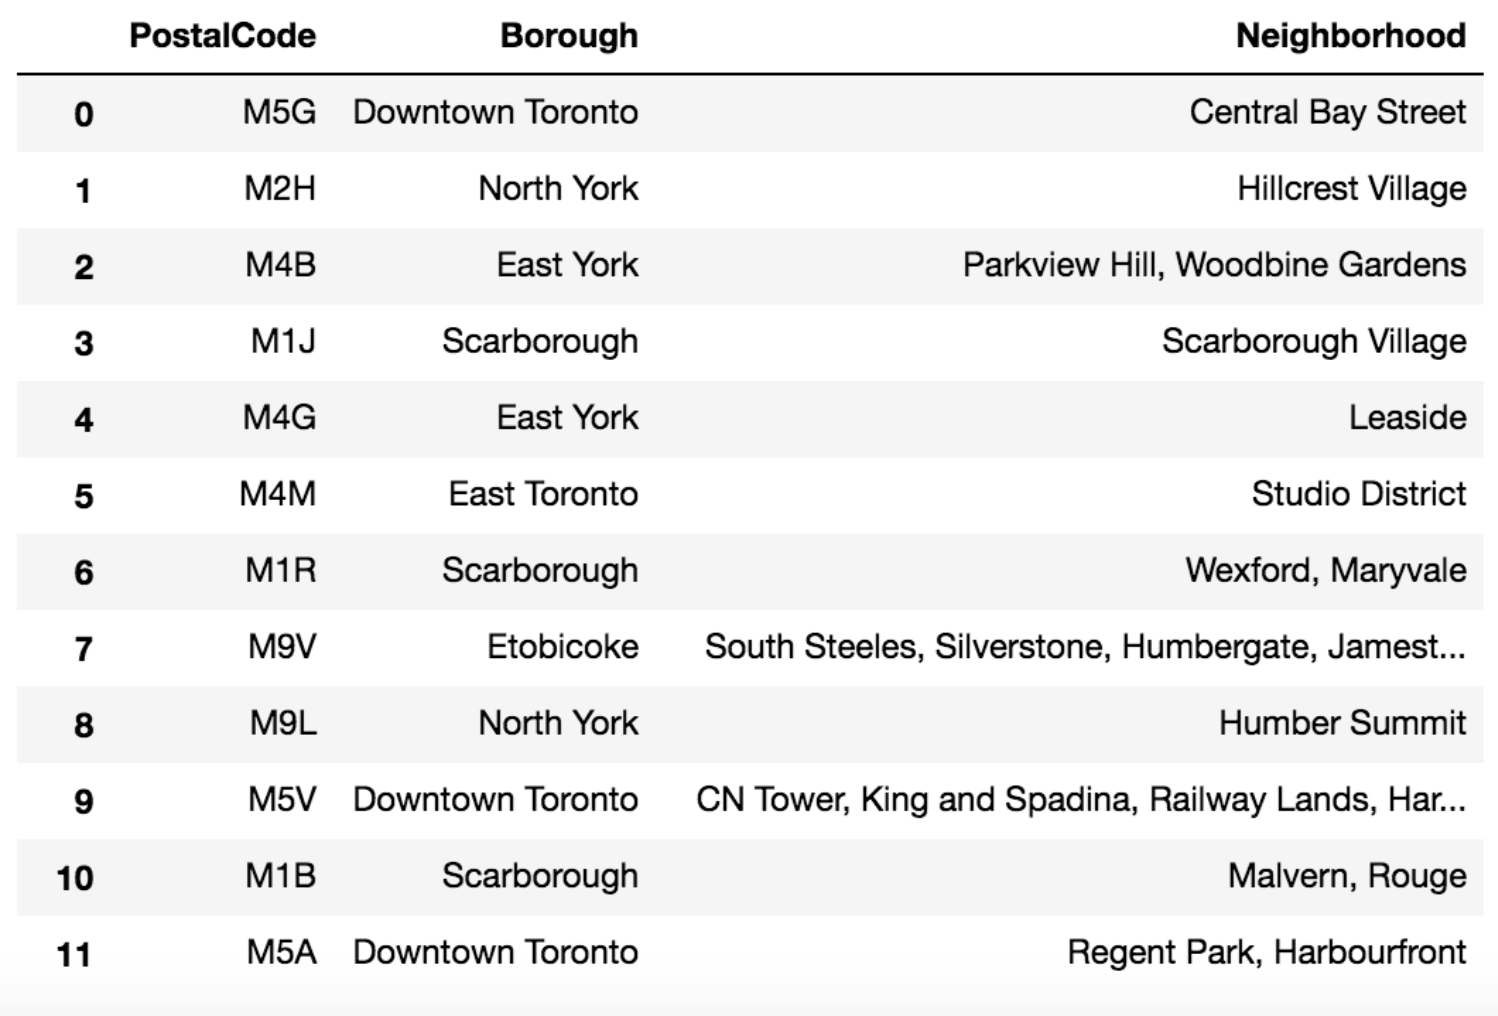

## Part 1).- Scrapping Wikipedia using BeautifulSoup

To create a dataframe similar to the one above we have to consider the following points :

* The dataframe will consist of three columns: PostalCode, Borough, and Neighborhood
* Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned.
* More than one neighborhood can exist in one postal code area. For example, in the table on the Wikipedia page, we can notice that M5A is listed twice and has two neighborhoods: Harbourfront and Regent Park. These two rows will be combined into one row with the neighborhoods separated with a comma as shown in row 11 in the above table.
* If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough.
* We present a clean Notebook and we add Markdown cells to explain our work and any assumptions we make.
* In the last cell of the notebook, we use the .shape method to print the number of rows of the dataframe.

In [ ]:
# We first install Beautiful Soup and requests for Web Scaping
!pip install BeautifulSoup4
!pip install requests

### Part 1.1).- Getting our data 

We consider the following steps:
* Importing the appropriate python libraries
* Use BeautifulSoup to parse the HTML data from Wikipedia 
* Store our data into a Pandas DataFrame

In [3]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np

#get html from wiki page and create soup object
source = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
soup = BeautifulSoup(source.text, 'lxml')

#using soup object, iterate the .wikitable to get the data from the HTML page and store it into a list
data = []
columns = []
table = soup.find(class_='wikitable')
for index, tr in enumerate(table.find_all('tr')):
    section = []
    for td in tr.find_all(['th','td']):
        section.append(td.text.rstrip())
    
    #First row of data is the header
    if (index == 0):
        columns = section
    else:
        data.append(section)

#convert list into Pandas DataFrame
canada_df = pd.DataFrame(data = data,columns = columns)
canada_df.head()

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


### Part 1.2).- Preparing our data

We consider the following steps:

* Remove all the Boroughs that are 'Not assigned'
* Because more than one neighborhood can exist in one postal code area, we can combine these into one row with the neighborhoods separated with a comma
* If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough

In [4]:
canada_df = canada_df[canada_df['Borough'] != 'Not assigned']
canada_df.head()

,Postcode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M6A,North York,Lawrence Heights
6,M6A,North York,Lawrence Manor


In [5]:
canada_df["Neighbourhood"] = canada_df.groupby("Postcode")["Neighbourhood"].transform(lambda neigh: ', '.join(neigh))

#remove duplicates
canada_df = canada_df.drop_duplicates()

#update index to be postcode if it isn't already
if(canada_df.index.name != 'Postcode'):
    canada_df = canada_df.set_index('Postcode')
    
canada_df.head()

,Borough,Neighbourhood
Postcode,,
M3A,North York,Parkwoods
M4A,North York,Victoria Village
M5A,Downtown Toronto,Harbourfront
M6A,North York,"Lawrence Heights, Lawrence Manor"
M7A,Downtown Toronto,Queen's Park


In [6]:
canada_df['Neighbourhood'].replace("Not assigned", canada_df["Borough"],inplace=True)
canada_df.head()

,Borough,Neighbourhood
Postcode,,
M3A,North York,Parkwoods
M4A,North York,Victoria Village
M5A,Downtown Toronto,Harbourfront
M6A,North York,"Lawrence Heights, Lawrence Manor"
M7A,Downtown Toronto,Queen's Park


### Part 1.3).- Required Output Data

Just as mentioned previously, we are required to use the `.shape` method to print the number of rows of the dataframe.

In [7]:
canada_df.shape

(103, 2)

## Part 2).- Adding Geospatial Data 

Now that we have built a dataframe of the postal code of each neighborhood along with the borough name and neighborhood name, in order to utilize the Foursquare location data, we need to get the latitude and the longitude coordinates of each neighborhood.

To accomplish the previous goal, we will use a link to a csv file that has the geographical coordinates of each postal code: http://cocl.us/Geospatial_data to get the latitude and the longitude coordinates of each neighborhood.

In [8]:
url="https://cocl.us/Geospatial_data"
lat_long_coord_df = pd.read_csv(url)

#rename columns and set the index to be Postcode
lat_long_coord_df.columns = ["Postcode", "Latitude", "Longitude"]
if(lat_long_coord_df.index.name != 'Postcode'):
    lat_long_coord_df = lat_long_coord_df.set_index('Postcode')
    
lat_long_coord_df.head()

,Latitude,Longitude
Postcode,,
M1B,43.806686,-79.194353
M1C,43.784535,-79.160497
M1E,43.763573,-79.188711
M1G,43.770992,-79.216917
M1H,43.773136,-79.239476


In [9]:
canada_df = canada_df.join(lat_long_coord_df)
canada_df.head(11)

,Borough,Neighbourhood,Latitude,Longitude
Postcode,,,,
M3A,North York,Parkwoods,43.753259,-79.329656
M4A,North York,Victoria Village,43.725882,-79.315572
M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
M6A,North York,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763
M7A,Downtown Toronto,Queen's Park,43.662301,-79.389494
M9A,Etobicoke,Islington Avenue,43.667856,-79.532242
M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
M3B,North York,Don Mills North,43.745906,-79.352188
M4B,East York,"Woodbine Gardens, Parkview Hill",43.706397,-79.309937


## Part 3).- Exploring and Clustering Data 

For this part we are required to explore and cluster the different neighborhoods in Toronto. We are given the option to decide to work with only boroughs that contain the word Toronto and then replicate the same analysis we did to the New York City data.

There, for this step we will consdier the following steps:
* Importing the remaining python libraries that we need
* Filtering the Canada data to only use boroughs in Toronto
* Showing an initial map of the neighborhoods in Toronto
* Utilizing the Foursquare API to explore the neighborhoods and segment them in more detail.

In [10]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

openssl-1.1.1d       | 2.1 MB    | ##################################### | 100% 
certifi-2019.11.28   | 149 KB    | ##################################### | 100% 
geopy-1.21.0         | 58 KB     | ##################################### | 100% 
geographiclib-1.50   | 34 KB     | ##################################### | 100% 
ca-certificates-2019 | 145 KB    | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    altair-4.0.1               |             py_0         575 KB  conda-forge
    branca-0.4.0               |             py_0          26 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  c

### Part 3.1).- Getting Toronto's Data 

In [12]:
toronto_df = canada_df[canada_df['Borough'].str.contains('Toronto')]
toronto_df.head()

,Borough,Neighbourhood,Latitude,Longitude
Postcode,,,,
M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
M7A,Downtown Toronto,Queen's Park,43.662301,-79.389494
M5B,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937
M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
M4E,East Toronto,The Beaches,43.676357,-79.293031


### Part 3.2).- Generating a Map

In [13]:
#Shows an initial map of the neighborhoods in Toronto
map_toronto = folium.Map(location=[toronto_df["Latitude"][0], toronto_df["Longitude"][0]], zoom_start=10)

# adds markers to map
for lat, lng, borough, neighborhood in zip(toronto_df['Latitude'], toronto_df['Longitude'], toronto_df['Borough'], toronto_df['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

### Part 3.3).- Leveraging Foursquare's API to Explore Neighborhoods

In [14]:
CLIENT_ID = 'VB2BBB1XXUATNZXP5N440IM3J5UVG2NXZC5B04Q05AN3GBS4' # my persona Foursquare ID
CLIENT_SECRET = '2UD2D1BRGCMQBHYOSM3T42IWKWJ2UKY0ICZZ3TVCKXFDEYSF' # my Foursquare Secret
VERSION = '20200309' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: VB2BBB1XXUATNZXP5N440IM3J5UVG2NXZC5B04Q05AN3GBS4
CLIENT_SECRET:2UD2D1BRGCMQBHYOSM3T42IWKWJ2UKY0ICZZ3TVCKXFDEYSF


We start by exploring one single neighborhood and gather some insights 

In [15]:
neighborhood_latitude = toronto_df['Latitude'][0] # neighborhood latitude value
neighborhood_longitude = toronto_df['Longitude'][0] # neighborhood longitude value

neighborhood_name = toronto_df['Neighbourhood'][0] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Harbourfront are 43.6542599, -79.3606359.


In [16]:
# Setup API URL to explore venues near by
LIMIT = 200
radius = 400
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, neighborhood_latitude, neighborhood_longitude, VERSION, radius, LIMIT)
neighborhood_json = requests.get(url).json()

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    
venues = neighborhood_json['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Roselle Desserts,Bakery,43.653447,-79.362017
1,Tandem Coffee,Coffee Shop,43.653559,-79.361809
2,Cooper Koo Family YMCA,Distribution Center,43.653249,-79.358008
3,Body Blitz Spa East,Spa,43.654735,-79.359874
4,Morning Glory Cafe,Breakfast Spot,43.653947,-79.361149


We can continue the process by generalizing the venue data collection. Here we can set up a method so that we get the data in a more generalized form we can easily recall

In [17]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    venues_list=[]
    
    for name, lat, lng in zip(names, latitudes, longitudes):
        # print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

We can proceed by getting venue data from all neighborhoods of Toronto

In [18]:
toronto_venues_df = getNearbyVenues(names=toronto_df['Neighbourhood'],
                                   latitudes=toronto_df['Latitude'],
                                   longitudes=toronto_df['Longitude']
                                  )

In [20]:
print(toronto_venues_df.shape)
toronto_venues_df.head()

(1721, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Harbourfront,43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,Harbourfront,43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,Harbourfront,43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,Harbourfront,43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
4,Harbourfront,43.65426,-79.360636,Morning Glory Cafe,43.653947,-79.361149,Breakfast Spot


In [21]:
toronto_venues_df.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Adelaide, King, Richmond",100,100,100,100,100,100
Berczy Park,56,56,56,56,56,56
"Brockton, Exhibition Place, Parkdale Village",24,24,24,24,24,24
Business Reply Mail Processing Centre 969 Eastern,17,17,17,17,17,17
"CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara",17,17,17,17,17,17
"Cabbagetown, St. James Town",46,46,46,46,46,46
Central Bay Street,81,81,81,81,81,81
"Chinatown, Grange Park, Kensington Market",86,86,86,86,86,86
Christie,18,18,18,18,18,18


In [22]:
print('There are {} uniques categories.'.format(len(toronto_venues_df['Venue Category'].unique())))

There are 232 uniques categories.


### Part 3.4).- Analyzing Neighborhoods 

In [23]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues_df[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues_df['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Market,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Harbourfront,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [24]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,Yoga Studio,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Market,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,"Adelaide, King, Richmond",0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.02,0.0,0.0,0.000000,0.0,0.02,0.000000,0.000000,0.0,0.000000,0.020000,0.0,0.030000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.02,0.000000,0.01,0.020000,0.000000,0.0,0.01,0.02,0.010000,0.0,0.000000,0.040000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.02,0.000000,0.070000,0.0,0.0,0.0,0.0,0.01,0.000000,0.000000,0.020000,0.000000,0.02,0.0,0.0,0.000000,0.0,0.0,0.0,0.01,0.010000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.010000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.01,0.0,0.000000,0.000000,0.0,0.0,0.0,0.010000,0.0,0.000000,0.00000

In [25]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide, King, Richmond----
              venue  freq
0       Coffee Shop  0.07
1        Restaurant  0.05
2   Thai Restaurant  0.04
3              Café  0.04
4  Sushi Restaurant  0.03


----Berczy Park----
            venue  freq
0     Coffee Shop  0.09
1    Cocktail Bar  0.04
2        Beer Bar  0.04
3  Farmers Market  0.04
4            Café  0.04


----Brockton, Exhibition Place, Parkdale Village----
                venue  freq
0                Café  0.12
1         Coffee Shop  0.08
2      Breakfast Spot  0.08
3         Yoga Studio  0.04
4  Italian Restaurant  0.04


----Business Reply Mail Processing Centre 969 Eastern----
                  venue  freq
0           Yoga Studio  0.06
1                   Spa  0.06
2  Gym / Fitness Center  0.06
3         Garden Center  0.06
4                Garden  0.06


----CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara----
              venue  freq
0   Airport Service  0.18
1    Airport 

In [26]:
#further sorting of  venues
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [27]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Restaurant,Thai Restaurant,Café,Bar,Sushi Restaurant,Gastropub,Lounge,Steakhouse,Gym
1,Berczy Park,Coffee Shop,Café,Bakery,Cheese Shop,Restaurant,Beer Bar,Farmers Market,Cocktail Bar,Seafood Restaurant,Greek Restaurant
2,"Brockton, Exhibition Place, Parkdale Village",Café,Coffee Shop,Breakfast Spot,Yoga Studio,Bakery,Convenience Store,Performing Arts Venue,Pet Store,Climbing Gym,Restaurant
3,Business Reply Mail Processing Centre 969 Eastern,Yoga Studio,Pizza Place,Skate Park,Burrito Place,Spa,Farmers Market,Fast Food Restaurant,Restaurant,Recording Studio,Light Rail Station
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",Airport Service,Airport Lounge,Airport Terminal,Boutique,Bar,Airport,Airport Food Court,Airport Gate,Sculpture Garden,Harbor / Marina


### Part 3.5).- Clustering Neighborhoods 

In [28]:
# set number of clusters
kclusters = int(len(toronto_df["Neighbourhood"].unique()) / 4)
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=1).fit(toronto_grouped_clustering)

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = toronto_df.copy()
toronto_merged.rename(columns={'Neighbourhood':'Neighborhood'}, inplace=True)
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Postcode,,,,,,,,,,,,,,,
M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636,7,Coffee Shop,Park,Bakery,Café,Pub,Mexican Restaurant,Breakfast Spot,Restaurant,Theater,Electronics Store
M7A,Downtown Toronto,Queen's Park,43.662301,-79.389494,7,Coffee Shop,Park,Burger Joint,Yoga Studio,Distribution Center,Beer Bar,Italian Restaurant,Seafood Restaurant,Juice Bar,Sandwich Place
M5B,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937,7,Coffee Shop,Clothing Store,Bubble Tea Shop,Café,Japanese Restaurant,Middle Eastern Restaurant,Italian Restaurant,Restaurant,Diner,Ramen Restaurant
M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,7,Coffee Shop,Café,Restaurant,Diner,Hotel,Italian Restaurant,Clothing Store,Cosmetics Shop,Beer Bar,Bakery
M4E,East Toronto,The Beaches,43.676357,-79.293031,4,Trail,Health Food Store,Pub,Women's Store,Department Store,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant


In [29]:
# create map
map_clusters = folium.Map(location=[toronto_df["Latitude"][0], toronto_df["Longitude"][0]], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters